# French Bonds Analysis
This notebook scrapes French funds data from tradingeconomics.com , performs analysis, and creates visualizations.

In [8]:
import numpy as np
import requests
import csv
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
sns.set_palette('deep')


c:\Users\egeuz\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Web Scraping

In [9]:
def scrape_french_bonds():
    url = 'https://tradingeconomics.com/france/20-year-bond-yield'
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'}
    
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Initialize lists to store data
        maturities = []
        yields = []
        
        # Find the table containing bond data
        table = soup.find('table')
        if table:
            rows = table.find_all('tr')[1:]  # Skip header row
            for row in rows:
                cols = row.find_all('td')
                if len(cols) >= 2:
                    maturities.append(cols[0].text.strip())
                    yields.append(float(cols[1].text.strip().replace('%', '')))
        
        # Create DataFrame
        df = pd.DataFrame({
            'Maturity': maturities,
            'Yield': yields
        })
        
        return df
    
    except Exception as e:
        print(f'Error scraping data: {e}')
        return None

# Fecth The Data

In [10]:
bonds_df = scrape_french_bonds()

if bonds_df is not None:
    print('French Government Bonds Data:')
    display(bonds_df)

French Government Bonds Data:


,Maturity,Yield
0,France 10Y,3.14
1,France 1M,2.38
2,France 52W,2.25
3,France 20Y,3.49
4,France 2Y,2.14
5,France 30Y,3.73
6,France 3M,2.40
7,France 3Y,2.25
8,France 5Y,2.53
9,France 6M,2.32


# Yield Curve

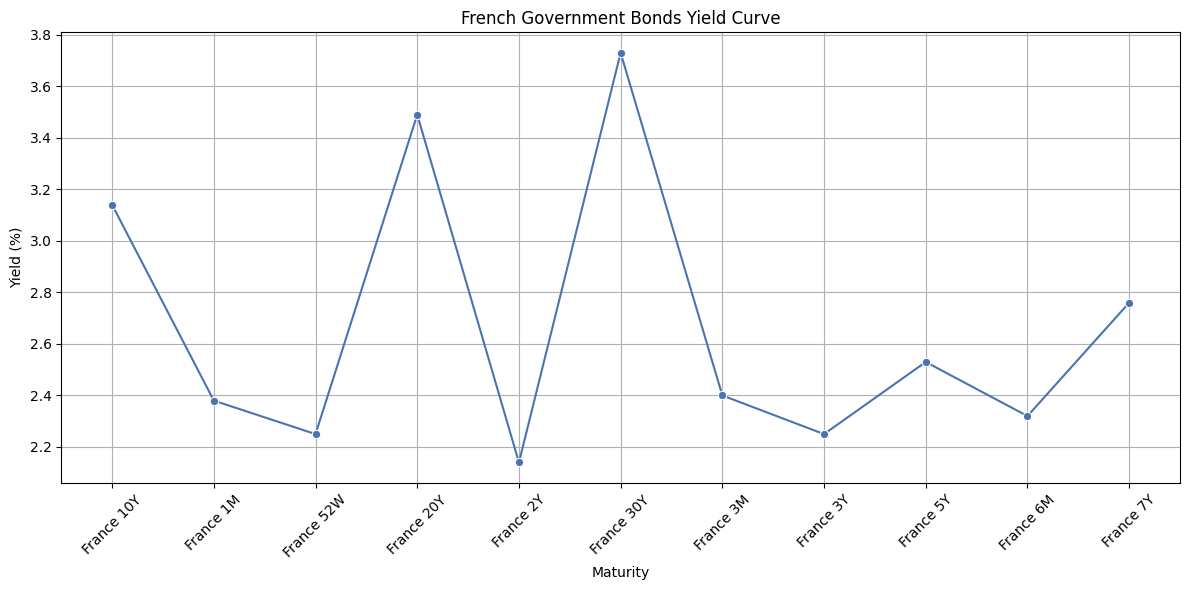

In [11]:
if bonds_df is not None:
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=bonds_df, x='Maturity', y='Yield', marker='o')
    plt.title('French Government Bonds Yield Curve')
    plt.xlabel('Maturity')
    plt.ylabel('Yield (%)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# The Statistical Information: Variance, Expected Value, Standard Deviation
The average yield of 2.74% indicates that the current yields on French government bonds are relatively moderate. Investors seeking very high yields may find this level less attractive compared to other higher-yielding asset classes, which would likely come with higher risk.The yield curve indicates a relatively flat environment. The low variance (0.29) and standard deviation (0.54%) point towards a relatively flat yield curve at the time of scraping the data. This implies that investors aren't being significantly compensated with higher yields for taking on longer-term maturity risk within the French government bond market, based on this data.

Implication for Maturity Selection: In a flatter yield curve environment, the decision of whether to invest in short-term or long-term French government bonds might be less driven by yield differences and more by factors like:Interest Rate Expectations: If investors anticipate interest rates to rise, they might prefer shorter-term bonds to reinvest at higher rates sooner. If they expect rates to fall, longer-term bonds could lock in current yields for longer.Investment Horizon: Shorter-term bonds are more suitable for shorter investment horizons, while longer-term bonds are better suited to longer-term liabilities or investment goals.



In [12]:
if bonds_df is not None:
    
    average_yield = bonds_df['Yield'].mean()
    variance_yield = bonds_df['Yield'].var()
    std_deviation_yield = bonds_df['Yield'].std()

    print("\nStatistics for Current Yield Curve Data:")
    print(f"Average Yield: {average_yield:.2f}")
    print(f"Variance of Yield: {variance_yield:.2f}")
    print(f"Standard Deviation of Yield: {std_deviation_yield:.2f}")
else:
    print("bonds_df is None.  Cannot calculate statistics.")


Statistics for Current Yield Curve Data:
Average Yield: 2.67
Variance of Yield: 0.30
Standard Deviation of Yield: 0.54


# Analysis of volatiles
 The analysis of historical volatility suggests that French 20-Year Government Bonds are currently experiencing a period of unusually high volatility. This presents both risks and potential opportunities. Risk-averse investors should be cautious and consider reducing exposure, while risk-seeking investors might find opportunities but need to manage risk carefully. All investors should stay informed and understand their own risk tolerance.

c:\Users\egeuz\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


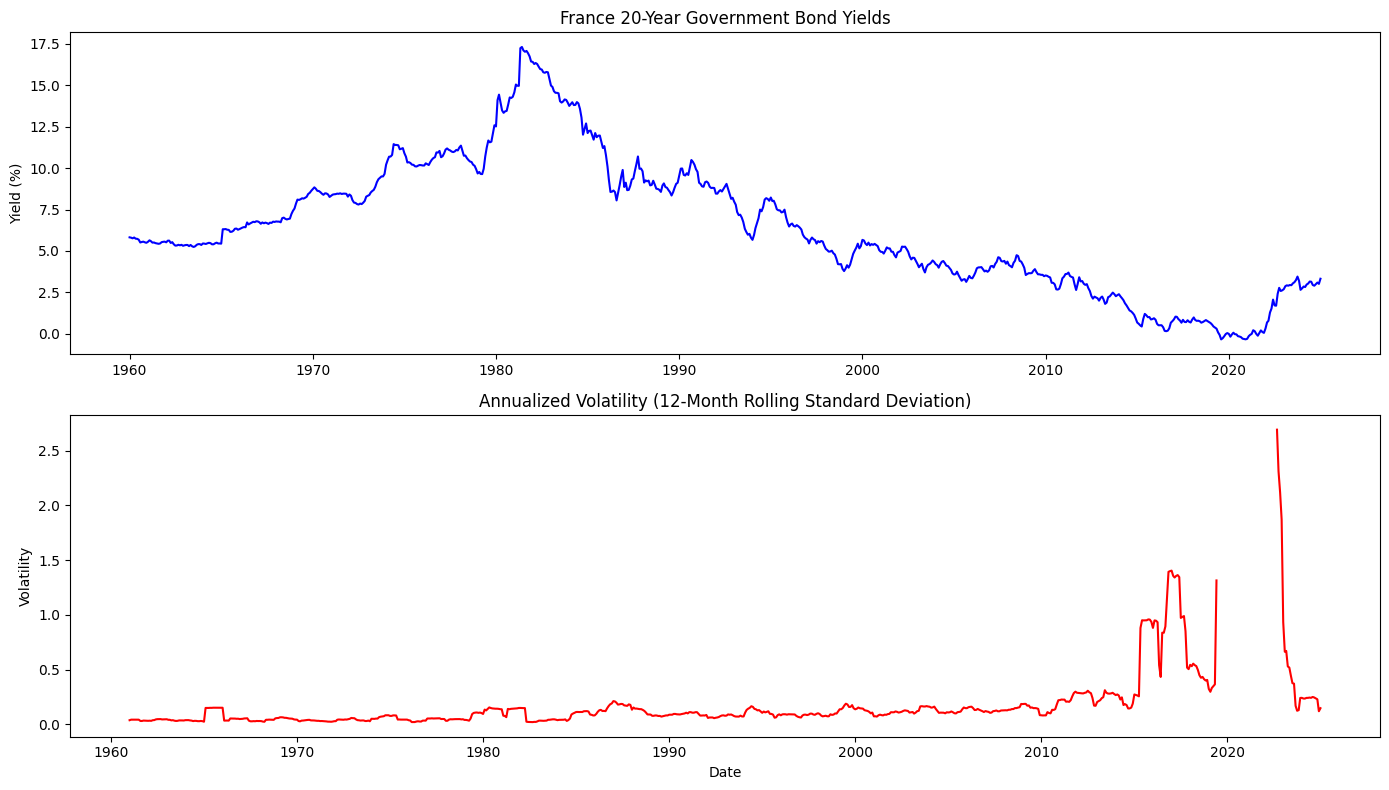

In [13]:
df = pd.read_csv('IRLTLT01FRM156N.csv', parse_dates=['observation_date'])
df.set_index('observation_date', inplace=True)
df.dropna(inplace=True)
df['log_return'] = np.log(df['IRLTLT01FRM156N'] / df['IRLTLT01FRM156N'].shift(1))

# Calculate annualized volatility (12-month rolling window, scaled by √12 for annualization)
window_size = 12
df['volatility'] = df['log_return'].rolling(window=window_size).std() * np.sqrt(12)

# Visualization
plt.figure(figsize=(14, 8))

# Plot bond yields
plt.subplot(2, 1, 1)
plt.plot(df.index, df['IRLTLT01FRM156N'], color='blue')
plt.title('France 20-Year Government Bond Yields')
plt.ylabel('Yield (%)')

# Plot volatility
plt.subplot(2, 1, 2)
plt.plot(df.index, df['volatility'], color='red')
plt.title('Annualized Volatility (12-Month Rolling Standard Deviation)')
plt.xlabel('Date')
plt.ylabel('Volatility')

plt.tight_layout()
plt.show()

# Spread Analysis (France-Germany Bond Spread)
Risk Indicator: The France-Germany 10-year bond spread reflects the perceived risk of France relative to Germany. A positive spread indicates that France is perceived as riskier. The wider the spread, the higher the relative risk of France.

Yield Opportunity: A higher spread implies a higher yield potential for French bonds relative to German bonds. This can be attractive for yield-seeking investors. However, this comes at a higher risk.

Dynamic and variable: The spread is not fixed. It changes constantly depending on economic conditions, political events and market sentiment. We have seen volatility and an uptrend, especially after 2017, with a significant widening after 2022.

Widening after 2022: The significant widening of the spread after 2022 reflects factors such as the war in Ukraine, the energy crisis, inflation and increased risk aversion. This led to increased demand for German Bunds and a widening of the spread.

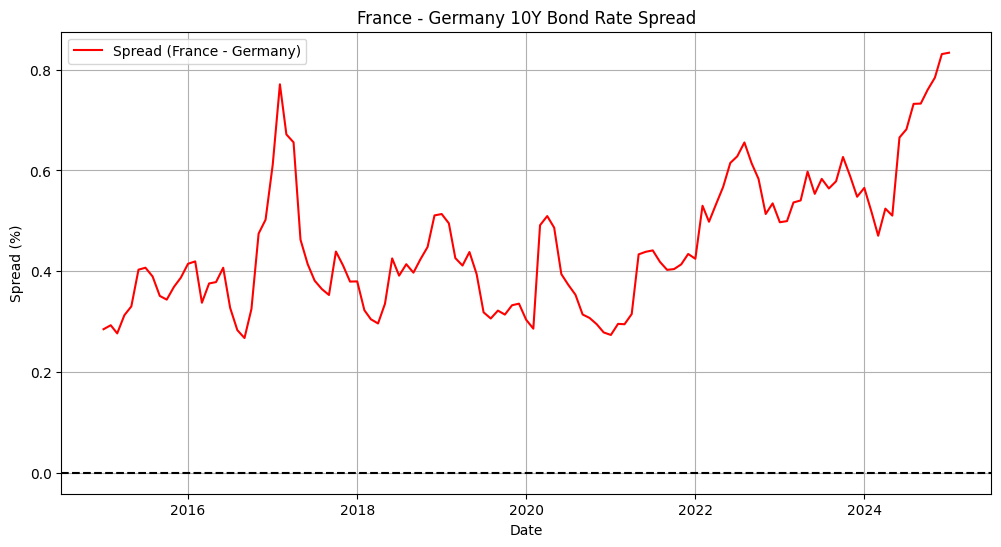

In [14]:
# Load the datasets
df_germany = pd.read_csv("IRLTLT01DEM140N.csv", parse_dates=["observation_date"], index_col="observation_date")
df_france = pd.read_csv("IRLTLT01FRM140N.csv", parse_dates=["observation_date"], index_col="observation_date")

# Create DataFrame with correct column names and calculate spread
df = pd.DataFrame()
df["OAT_10Y"] = df_france["IRLTLT01FRM156N"]
df["Bund_10Y"] = df_germany["IRLTLT01DEM156N"]
df["Spread (OAT-Bund)"] = df["OAT_10Y"] - df["Bund_10Y"]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Spread (OAT-Bund)"], label="Spread (France - Germany)", color="red")
plt.axhline(y=0, color="black", linestyle="--")
plt.title("France - Germany 10Y Bond Rate Spread")
plt.xlabel("Date")
plt.ylabel("Spread (%)")
plt.legend()
plt.grid(True)
plt.show()


# Forecasting German and French 10-Year Bond Yields: ARIMA and Prophet Models
The chart shows that French 10-year bond yields may remain at low levels or fall further in the future. Investors should view this as a low-yield environment and adjust their portfolio strategies accordingly. However, given the uncertainty of forecasts and the volatility of the economic environment, they should make their investment decisions with a broader perspective and by evaluating different data sources.

16:15:32 - cmdstanpy - INFO - Chain [1] start processing
16:15:32 - cmdstanpy - INFO - Chain [1] done processing


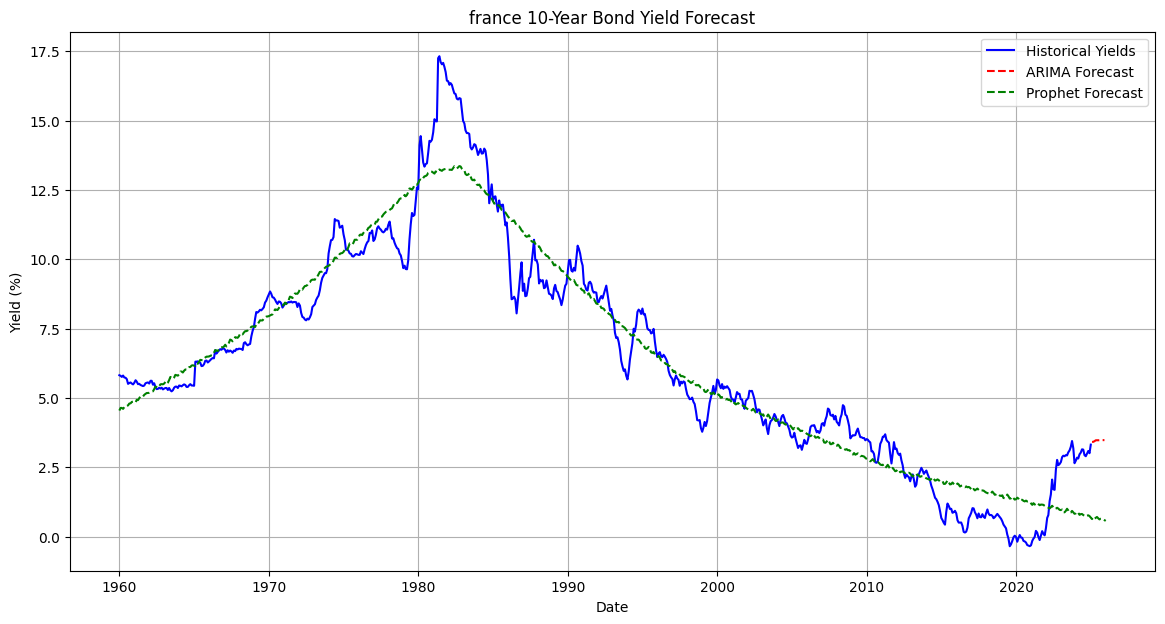

ARIMA Forecast:
2025-01-01         NaN
2025-02-01    3.417738
2025-03-01    3.419323
2025-04-01    3.441473
2025-05-01    3.474275
2025-06-01    3.477122
2025-07-01    3.475768
2025-08-01    3.479815
2025-09-01    3.482100
2025-10-01    3.481502
2025-11-01    3.481524
2025-12-01    3.482037
Freq: MS, Name: predicted_mean, dtype: float64

Prophet Forecast:
            ds      yhat
781 2025-02-01  0.635902
782 2025-03-01  0.697784
783 2025-04-01  0.647268
784 2025-05-01  0.680469
785 2025-06-01  0.711695
786 2025-07-01  0.665860
787 2025-08-01  0.624410
788 2025-09-01  0.646354
789 2025-10-01  0.644567
790 2025-11-01  0.636402
791 2025-12-01  0.599850
792 2026-01-01  0.568394


In [ ]:

df_germany = pd.read_csv("IRLTLT01DEM140N.csv", parse_dates=["observation_date"], index_col="observation_date")
df_france = pd.read_csv("IRLTLT01FRM156N.csv", parse_dates=["observation_date"], index_col="observation_date")

data = df_france['IRLTLT01FRM156N'].dropna()
data = data.asfreq('MS') 

order = (5, 1, 0) 
model_arima = ARIMA(data, order=order)
model_arima_fit = model_arima.fit()

forecast_arima = model_arima_fit.forecast(steps=12)
forecast_index_arima = pd.date_range(data.index[-1], periods=12, freq='MS')
forecast_arima_series = pd.Series(forecast_arima, index=forecast_index_arima)

df_prophet = df_france[['IRLTLT01FRM156N']].reset_index()
df_prophet.columns = ['ds', 'y']
df_prophet.dropna(inplace=True)

model_prophet = Prophet()
model_prophet.fit(df_prophet)

future_prophet = model_prophet.make_future_dataframe(periods=12, freq='MS') 
forecast_prophet = model_prophet.predict(future_prophet)


# Visualization 
plt.figure(figsize=(14, 7))

plt.plot(data.index, data, label='Historical Yields', color='blue')

plt.plot(forecast_arima_series.index, forecast_arima_series, label='ARIMA Forecast', color='red', linestyle='--')

plt.plot(forecast_prophet['ds'], forecast_prophet['yhat'], label='Prophet Forecast', color='green', linestyle='--')

plt.title('France 10-Year Bond Yield Forecast')
plt.xlabel('Date')
plt.ylabel('Yield (%)')
plt.legend()
plt.grid(True)
plt.show()

print("ARIMA Forecast:")
print(forecast_arima_series)
print("\nProphet Forecast:")
print(forecast_prophet[['ds', 'yhat']].tail(12))

# Scikit-learn for German Bond Yield Forecasting
The forecast of the scikit-learn model for German 10-year bond yields suggests that no further large increases in yields are expected, but rather a flat or slightly downward trend. This may mean that for those looking to invest in German and possibly French bonds, current yield levels may be attractive, but the prospects for large yield increases may be limited. Investors considering investing in French government bonds can use the German market analysis as a reference point, but should also examine the economic and political factors specific to France in detail and determine an investment strategy that suits their own risk tolerance. As always, the best approach is not to rely on a single chart or model, but to make investment decisions based on a comprehensive analysis and consideration of different data sources.

Root Mean Squared Error (RMSE) on Test Set: 0.23


c:\Users\egeuz\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\egeuz\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\egeuz\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\egeuz\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\egeuz\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py

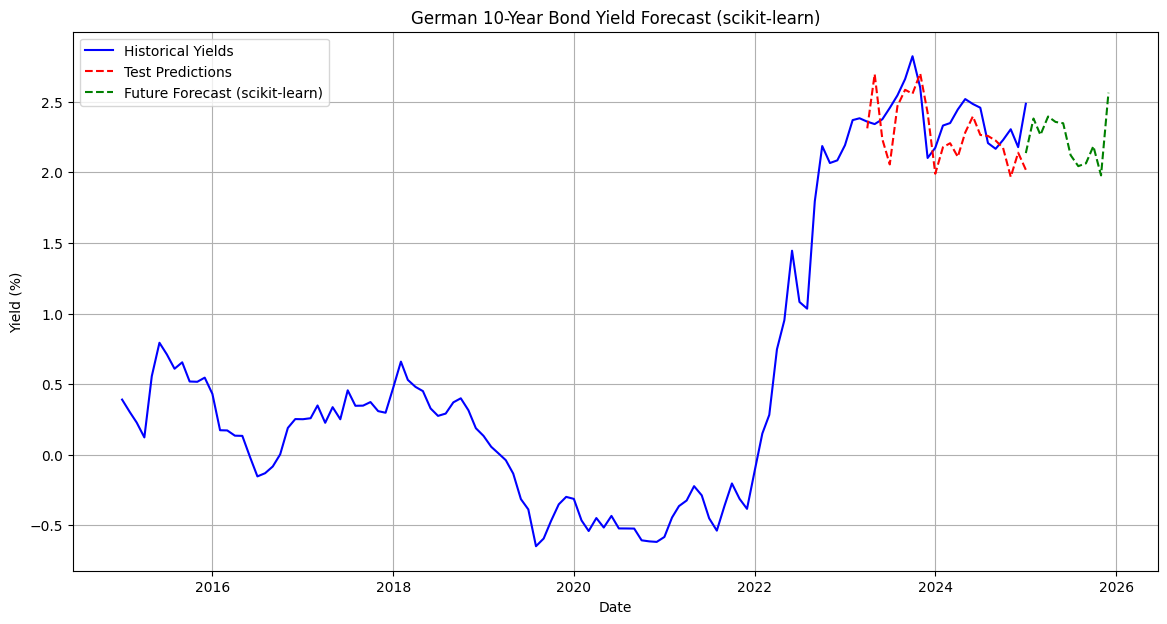


Scikit-learn Forecast (Next 12 Months):
2025-01-01    2.136810
2025-02-01    2.381629
2025-03-01    2.265342
2025-04-01    2.396136
2025-05-01    2.357567
2025-06-01    2.348168
2025-07-01    2.122337
2025-08-01    2.044208
2025-09-01    2.063880
2025-10-01    2.185957
2025-11-01    1.978394
2025-12-01    2.564459
Freq: MS, dtype: float64


In [16]:
df = pd.read_csv("IRLTLT01DEM140N.csv", parse_dates=["observation_date"], index_col="observation_date")
df.dropna(inplace=True)

# Feature Engineering (Lagged Features)
def create_lagged_features(df, lags=12):
    df_Lagged = df.copy()
    for i in range(1, lags + 1):
        df_Lagged[f'lag_{i}'] = df_Lagged['IRLTLT01DEM156N'].shift(i)
    df_Lagged.dropna(inplace=True)
    return df_Lagged

df_lagged = create_lagged_features(df)

X = df_lagged[['lag_'+str(i) for i in range(1, 13)]] 
y = df_lagged['IRLTLT01DEM156N']

train_size = int(len(df_lagged) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Model Training (Linear Regression)
model = LinearRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE) on Test Set: {rmse:.2f}')


#Forecasting Future Values
def forecast(model, df, periods=12, lags=12):
    forecast_values = []
    last_window = df[['IRLTLT01DEM156N']].tail(lags).values.flatten() # Get the last 'lags' values

    for _ in range(periods):
        X_future = last_window.reshape(1, -1) 
        prediction = model.predict(X_future)[0] 
        forecast_values.append(prediction)
        last_window = np.roll(last_window, -1) 
        last_window[-1] = prediction 

    forecast_index = pd.date_range(df.index[-1], periods=periods, freq='MS')
    forecast_series = pd.Series(forecast_values, index=forecast_index)
    return forecast_series


forecast_Sklearn = forecast(model, df_germany, periods=12)


#Visualization
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['IRLTLT01DEM156N'], label='Historical Yields', color='blue')
plt.plot(y_test.index, predictions, label='Test Predictions', color='red', linestyle='--')
plt.plot(forecast_Sklearn.index, forecast_Sklearn, label='Future Forecast (scikit-learn)', color='green', linestyle='--')

plt.title('German 10-Year Bond Yield Forecast (scikit-learn)')
plt.xlabel('Date')
plt.ylabel('Yield (%)')
plt.legend()
plt.grid(True)
plt.show()

print("\nScikit-learn Forecast (Next 12 Months):")
print(forecast_Sklearn)